# **Capítulo 7: Técnicas avanzadas**

## Caso de estudio

En siguiente caso de estudio vamos a poner en práctica lo aprendido en la sección 7 del libro. Para ello, en este caso vamos a usar otro conjunto de datos, en concreto el dataset CIFAR10. Este contiene imágenes etiquetadas sobre distintos animales y vehículos.

### Importamos las librerías necesarias

In [ ]:
import torch
import numpy as np
print(f'Versión de PyTorch: {torch.__version__}')


### Semillas para garantizar la reproducibilidad y establecer device (CPU o GPU)

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# Algoritmos sean deterministas (misma inicialización, etc. )
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


### Obtención de datos

En esta sección vamos a obtener los datos de entrenamiento, validación y test Como se ha visto secciones anteriores un buen método para seleccionar el mejor modelo es usar la técnica de Early Stopping.

Para ello nos guardaremos el modelo que mejor precisión obtenga en este subconjunto de validación, que será obteindo de los datos de entrenamiento. Vamos a dividir el conjunto de entrenamiento en 80% para entrenar y 20% para validar. Finalmente se medirá el rendimiento del modelo en el conjunto de test.

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 256
train_dataset = datasets.CIFAR10(
    root='./data', # Ruta donde se almacenarán los datos descargados
    train=True,     # Datos de entrenamiento
    transform=transforms.ToTensor(), # Conversión más normalización
    download=True   # Se descargan a la carpeta indicada en root
)

# WARNING, QUITAR SOLO PARA VER QUE FUNCIONA
# ---------------
# num_train = int(len(train_dataset) * 0.05) # WARNING, QUITAR SOLO PARA VER QUE FUNCIONA

# ---------------
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(num_train * 0.8))

np.random.shuffle(indices)

# Creamos los samplers que nos darán para cada split
# sólo los indices indicamos del mismo dataset
train_idx, valid_idx = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(
    train_dataset,  # Dataset sobre el que iterar
    batch_size=batch_size,
    sampler=train_sampler,
    shuffle=False    # Ponemos shuffle a false ya que el shuffle lo hará el SubsetRandomSampler
)

valid_loader = torch.utils.data.DataLoader(
    train_dataset,  # Dataset sobre el que iterar
    batch_size=batch_size,
    sampler=valid_sampler,
    shuffle=False    # Ponemos shuffle a false ya que el shuffle lo hará el SubsetRandomSampler
)

test_dataset = datasets.CIFAR10(
    root='./data', # Misma ruta que los datos de entrenamiento
    train=False,    # Datos de test
    transform=transforms.ToTensor() # Conversión más normalización
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False   # Los datos se testean siempre en el mismo orden
)

Files already downloaded and verified


Tamaño del conjunto de entrenamiento: 40000
Tamaño del conjunto de validación: 10000
Tamaño del conjunto de test: 10000
Tamaño de las imágenes: torch.Size([3, 32, 32])


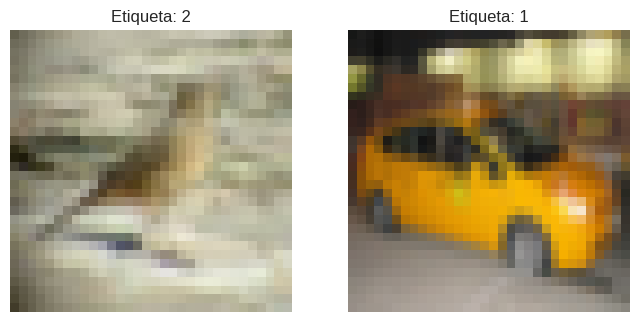

In [ ]:
import matplotlib.pyplot as plt

# Dimensiones de los conjuntos de datos
print(f'Tamaño del conjunto de entrenamiento: {len(train_idx)}')
print(f'Tamaño del conjunto de validación: {len(valid_idx)}')
print(f'Tamaño del conjunto de test: {len(test_dataset)}')


# Obtenemos un lote o batch de imágenes de entrenamiento
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f'Tamaño de las imágenes: {images.shape[1:]}') # [1:] -> Nos saltamos la dimensión del batch

# Visualizamos las imágenes y etiquetas de un batch de entrenamiento
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
for i in range(2):
    axs[i].imshow(images[i].permute(1, 2, 0))
    axs[i].set_title(f'Etiqueta: {labels[i]}')
    axs[i].axis('off')
plt.show()

### Creación del modelo

In [ ]:
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, normalization="", dropout=""):
        super(CNN, self).__init__()
        # Creamos la capa de normalización acorde al parámetro de entrada
        self.normalization = normalization if normalization != "" else None

        # Capas:
        # 1) Bloque extractor de características
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Añadimos la primera capa de normalización
        if self.normalization is not None:
          self.norm1 = nn.BatchNorm2d(16) if normalization == "batchnorm" else nn.LayerNorm([16, 16, 16])
        else:
          self.norm1 = nn.Identity()

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Añadimos la segunda capa de normalización
        if self.normalization is not None:
          self.norm2 = nn.BatchNorm2d(32) if normalization == "batchnorm" else nn.LayerNorm([32, 8, 8])
        else:
          self.norm2 = nn.Identity()


        # 2) Bloque clasificador de características
        self.flatten = nn.Flatten()

        # Añadimos dropout
        self.dropout = nn.Identity()
        if dropout != "":
          self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # Activaciones:
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        y = self.fc3(x)
        return y

# model = CNN(normalization="batchnorm", dropout=0.5).to(device)
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): Identity()
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Identity()
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


### Funciones para entrenar y testear el modelo

In [ ]:
def epoch_train(model, train_loader, optimizer, criterion, augmentations):
    epoch_losses = []
    # Iteramos sobre los datos de entrenamiento
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        if augmentations is not None:
          images = augmentations(images)
        # Ponemos los gradientes a cero
        optimizer.zero_grad()
        # Calculamos las salidas de la red neuronal para las imágenes de entrada
        outputs = model(images)
        # Calculamos la pérdida de la red neuronal
        loss = criterion(outputs, labels)
        # Calculamos los gradientes de la pérdida respecto a los parámetros de la red neuronal
        loss.backward()
        # Actualizamos los parámetros de la red neuronal usando el algoritmo de optimización
        optimizer.step()
        # Añadimos a la lista de pérdidas la pérdida actual
        epoch_losses.append(loss.item())
    # Calculamos la media de las pérdidas para una época
    epoch_losses = sum(epoch_losses) / len(epoch_losses)
    return epoch_losses

def test_model(model, test_loader):
    # Establecemos la red neuronal en modo de evaluación
    model.eval()
    # Desactivamos el cálculo de gradientes
    with torch.no_grad():
        correct = 0
        total = 0
        # Iteramos sobre los datos de validación
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Calculamos las salidas de la red neuronal para las imágenes de entrada
            outputs = model(images)
            # Calculamos las probabilidades de las clases
            outputs = outputs.softmax(dim=1)
            # Obtenemos la clase con mayor probabilidad
            predicted = outputs.argmax(dim=1)
            # Incrementamos el contador de imágenes procesadas
            total += labels.size(0)
            # Incrementamos el contador de imágenes clasificadas correctamente
            correct += (predicted == labels).sum().item()
        # Calculamos la precisión
        accuracy = 100 * correct / total
    # Establecemos la red neuronal en modo entrenamiento
    model.train()
    return accuracy

In [ ]:

def train_model(model, epochs, train_loader, val_loader, optimizer, criterion, augmentations, early_stopping, patience, path_ckpt):

  # Histórico de valores de precisión de entrenamiento y validacion
  train_accs, valid_accs = [], []

  # Inicializamos el mejor accuracy por si hay Early Stopping
  if early_stopping is True:
    print(f'Entrenamiento con Early Stopping. ES= {early_stopping} y {patience} épocas de paciencia')
    best_accuracy, times_no_improv = -1e9, patience-1

  else:
    print(f'Entrenamiento sin Early Stopping. ES={early_stopping}.')

  # Iteramos por cada época
  for epoch in range(epochs):
      # Entrenamos la red neuronal por una época
      train_loss = epoch_train(model, train_loader, optimizer, criterion, augmentations)
      # Calculamos la precisión para los datos de entrenamiento
      train_accuracy = test_model(model, train_loader)
      train_accs.append(train_accuracy)
      # Calculamos la precisión para los datos de validación
      valid_accuracy = test_model(model, valid_loader)
      valid_accs.append(valid_accuracy)

      if early_stopping is True:
        # Guardamos el modelo que mejor accuracy haya obtenido en validación
        if valid_accuracy > best_accuracy:
          best_accuracy = valid_accuracy
          times_no_improv = patience-1
          torch.save(model.state_dict(), path_ckpt)
          print(f'Nueva mejora en validación! {best_accuracy} Se guarda el modelo {path_ckpt}')
        else:
          times_no_improv -= 1
      else:
        # Guardamos el modelo con independencia de saber si ha mejorado o no
        torch.save(model.state_dict(), path_ckpt)

      # Sacamos los resultados por pantalla
      print(f'Época {epoch+1}/{epochs}, \
      pérdida_entrenamiento={train_loss:.4f},\
      tasa_de_acierto_entrenamiento={train_accuracy:.2f}%, \
      tasa_de_acierto_validación={valid_accuracy:.2f}%')

      if early_stopping is True and times_no_improv == 0:
        print(f'No se ha mejorado la validación en {patience} épocas.')
        break

    # Se ha completado el entrenamiento de la red neuronal

  return train_accs, valid_accs

In [ ]:
# Vamos a crear un diccionario para guardar los resultados
# en test de todos los modelos y luego poder hacer una comparativa
results_test = dict()

In [ ]:
# Hiperparámetros comunes
# Epocas
epochs = 50
# Función de pérdida de entropía cruzada
criterion = nn.CrossEntropyLoss()
# Paciencia
patience = 15

## Modelo base

Para entrar al modelo base, lo que haremos únicamente será pasarle los datos de entrenamiento y de validación. Dado que no vamos a aplicar la técnica de Early Stopping, obtendremos simplemente el último modelo actualizado.


In [ ]:
import torch.optim as optim

# Instanciamos el modelo
model = CNN().to(device)
print(model)

# Learning rate de 0.001 por defecto
optimizer = optim.Adam(model.parameters())

# Augmentations
augmentations = None

# Nombre modelo
model_name = "baseline"
print(f'Entrenamiento sin Early Stopping ni regularización')
train_accs, valid_accs = train_model(model, epochs, train_loader, valid_loader, optimizer, criterion, augmentations, False, patience, model_name + ".pt")
print('Fin del entrenamiento.')

model = CNN().to(device)
model.load_state_dict(torch.load(model_name + ".pt"))

# Obtenemos el accuracy del modelo en validación y en test
val_accuracy = test_model(model, valid_loader)
print(f'Tasa de acierto de validación = {val_accuracy:.2f}%')

test_accuracy = test_model(model, test_loader)
print(f'Tasa de acierto de test = {test_accuracy:.2f}%')

results_test[model_name] = test_accuracy


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): Identity()
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Identity()
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
Entrenamiento sin Early Stopping ni regularización
Entrenamiento sin Early Stopping. ES=False.
Época 1/50,       pérdida_entrenamiento=1.8247,      precisión_entrenamiento=43.51%,       precisión_validación=43.46%
Época 2/50,       pérdida_entrenamiento=1.4828,      precisión_entrenamiento=48.05%,       precisión_validación=47.52%
Época 3/50,       pérd

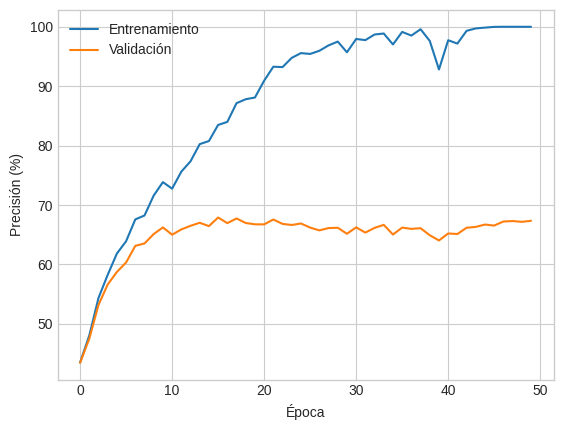

In [ ]:
plt.plot(train_accs)
plt.plot(valid_accs)
plt.xlabel('Época')     # Eje X - Época
plt.ylabel('Tasa de acierto (%)')   # Eje Y - Tasa de acierto
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

## Modelo con mejoras

En este apartado, vamos a construir modelos con las distintas mejoras propuestas en la sección del libro a ver cómo influye en el rendimiento final.

En concreto, las técnicas aplicadas serán:

*   Early Stopping
*   Aumentado de datos (rotaciones, flips horizionales y jittering)
*   Dropout
*   Batch Normalization
*   Layer Normalization


### Modelo con Early Stopping


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): Identity()
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Identity()
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
Entrenamiento con Early Stopping. ES= True y 15 épocas de paciencia
Nueva mejora en validación! 41.17 Se guarda el modelo ES.pt
Época 1/50,       pérdida_entrenamiento=1.8175,      precisión_entrenamiento=41.35%,       precisión_validación=41.17%
Nueva mejora en validación! 41.44 Se guarda el modelo ES.pt
Época 2/50,       pérdida_entrenamiento=1.4741, 

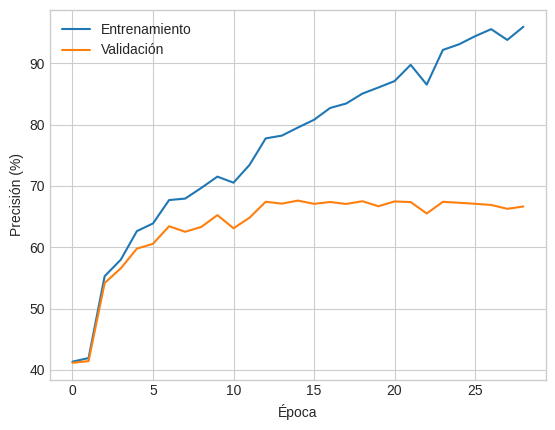

In [ ]:
# Instanciamos el modelo
model = CNN().to(device)
print(model)

# Learning rate de 0.001 por defecto
optimizer = optim.Adam(model.parameters())

# Augmentations
augmentations = None

# Nombre modelo
model_name = "ES"

train_accs, valid_accs = train_model(model, epochs, train_loader, valid_loader, optimizer, criterion, augmentations, True, patience, model_name + ".pt")
print('Fin del entrenamiento.')

model = CNN().to(device)
model.load_state_dict(torch.load(model_name + ".pt"))

# Obtenemos el accuracy del modelo en validación y en test
val_accuracy = test_model(model, valid_loader)
print(f'Tasa de acierto de validación = {val_accuracy:.2f}%')

test_accuracy = test_model(model, test_loader)
print(f'Tasa de acierto de test = {test_accuracy:.2f}%')

results_test[model_name] = test_accuracy


plt.plot(train_accs)
plt.plot(valid_accs)
plt.xlabel('Época')     # Eje X - Época
plt.ylabel('Tasa de acierto (%)')   # Eje Y - Tasa de acierto
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

### Modelo con aumentado de datos


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): Identity()
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Identity()
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
Entrenamiento con Early Stopping. ES= True y 15 épocas de paciencia
Nueva mejora en validación! 42.65 Se guarda el modelo ES+AUG.pt
Época 1/50,       pérdida_entrenamiento=1.8437,      precisión_entrenamiento=42.93%,       precisión_validación=42.65%
Nueva mejora en validación! 46.8 Se guarda el modelo ES+AUG.pt
Época 2/50,       pérdida_entrenamiento=1

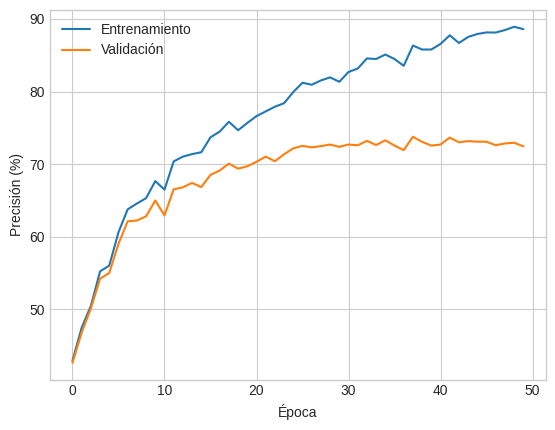

In [ ]:
import torch.optim as optim
from torchvision.transforms import Lambda

# Instanciamos el modelo
model = CNN().to(device)
print(model)

# Learning rate de 0.001 por defecto
optimizer = optim.Adam(model.parameters())

# Augmentations
augmentations = transforms.Compose([
    Lambda(lambda img: img * 255.), # Denormalize imagen
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(),]), p=0.3),
    Lambda(lambda img: img / 255.) # Normalizar imagen
  ]
)

# Nombre modelo
model_name = "ES+AUG"

train_accs, valid_accs = train_model(model, epochs, train_loader, valid_loader, optimizer, criterion, augmentations, True, patience, model_name + ".pt")
print('Fin del entrenamiento.')

model = CNN().to(device)
model.load_state_dict(torch.load(model_name + ".pt"))

# Obtenemos el accuracy del modelo en validación y en test
val_accuracy = test_model(model, valid_loader)
print(f'Tasa de acierto de validación = {val_accuracy:.2f}%')

test_accuracy = test_model(model, test_loader)
print(f'Tasa de acierto de test = {test_accuracy:.2f}%')

results_test[model_name] = test_accuracy


plt.plot(train_accs)
plt.plot(valid_accs)
plt.xlabel('Época')     # Eje X - Época
plt.ylabel('Tasa de acierto (%)')   # Eje Y - Tasa de acierto
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

### Modelo con Dropout


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): Identity()
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
Entrenamiento con Early Stopping. ES= True y 15 épocas de paciencia
Nueva mejora en validación! 39.37 Se guarda el modelo ES+AUG+DROP.pt
Época 1/50,       pérdida_entrenamiento=1.9482,      precisión_entrenamiento=39.28%,       precisión_validación=39.37%
Nueva mejora en validación! 48.01 Se guarda el modelo ES+AUG+DROP.pt
Época 2/50,

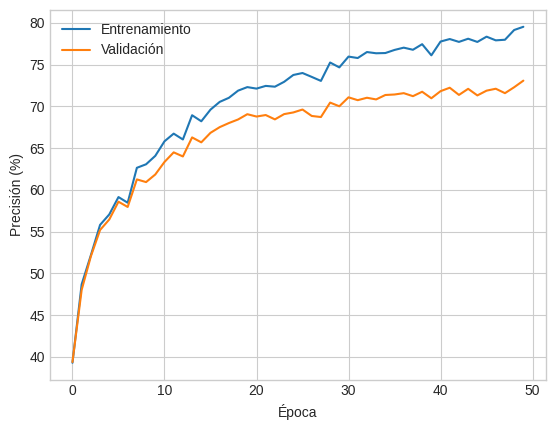

In [ ]:
# Instanciamos el modelo
model = CNN(dropout=0.5).to(device)
print(model)

# Learning rate de 0.001 por defecto
optimizer = optim.Adam(model.parameters())

# Augmentations
augmentations = transforms.Compose([
    Lambda(lambda img: img * 255.), # Denormalize imagen
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(),]), p=0.3),
    Lambda(lambda img: img / 255.) # Normalizar imagen
  ]
)

# Nombre modelo
model_name = "ES+AUG+DROP"

train_accs, valid_accs = train_model(model, epochs, train_loader, valid_loader, optimizer, criterion, augmentations, True, patience, model_name + ".pt")
print('Fin del entrenamiento.')

model = CNN(dropout=0.5).to(device)
model.load_state_dict(torch.load(model_name + ".pt"))

# Obtenemos el accuracy del modelo en validación y en test
val_accuracy = test_model(model, valid_loader)
print(f'Tasa de acierto de validación = {val_accuracy:.2f}%')

test_accuracy = test_model(model, test_loader)
print(f'Tasa de acierto de test = {test_accuracy:.2f}%')

results_test[model_name] = test_accuracy


plt.plot(train_accs)
plt.plot(valid_accs)
plt.xlabel('Época')     # Eje X - Época
plt.ylabel('Tasa de acierto (%)')   # Eje Y - Tasa de acierto
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

### Modelo con Batch Normalization


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
Entrenamiento con Early Stopping. ES= True y 15 épocas de paciencia
Nueva mejora en validación! 49.9 Se guarda el modelo ES+AUG+DROP+BN.pt
Época 1/50,       pérdida_entrenamiento=1.6432,      precis

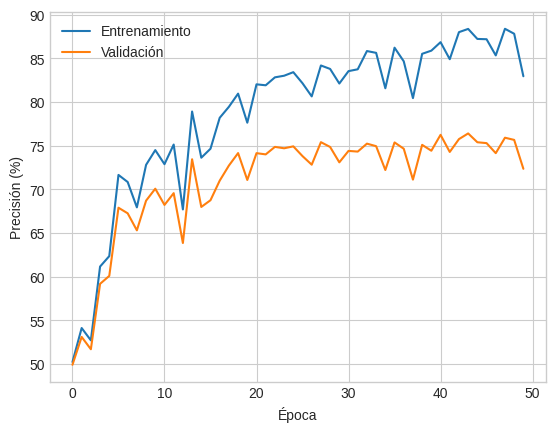

In [ ]:
# Instanciamos el modelo
model = CNN(dropout=0.5, normalization="batchnorm").to(device)
print(model)

# Learning rate de 0.001 por defecto
optimizer = optim.Adam(model.parameters())

# Augmentations
augmentations = transforms.Compose([
    Lambda(lambda img: img * 255.), # Denormalize imagen
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(),]), p=0.3),
    Lambda(lambda img: img / 255.) # Normalizar imagen
  ]
)

# Nombre modelo
model_name = "ES+AUG+DROP+BN"

train_accs, valid_accs = train_model(model, epochs, train_loader, valid_loader, optimizer, criterion, augmentations, True, patience, model_name + ".pt")
print('Fin del entrenamiento.')

model = CNN(dropout=0.5, normalization="batchnorm").to(device)
model.load_state_dict(torch.load(model_name + ".pt"))

# Obtenemos el accuracy del modelo en validación y en test
val_accuracy = test_model(model, valid_loader)
print(f'Tasa de acierto de validación = {val_accuracy:.2f}%')

test_accuracy = test_model(model, test_loader)
print(f'Tasa de acierto de test = {test_accuracy:.2f}%')

results_test[model_name] = test_accuracy


plt.plot(train_accs)
plt.plot(valid_accs)
plt.xlabel('Época')     # Eje X - Época
plt.ylabel('Tasa de acierto (%)')   # Eje Y - Tasa de acierto
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

### Modelo con Layer Normalization


Precisión de validación = 75.91%
Precisión de test = 75.44%


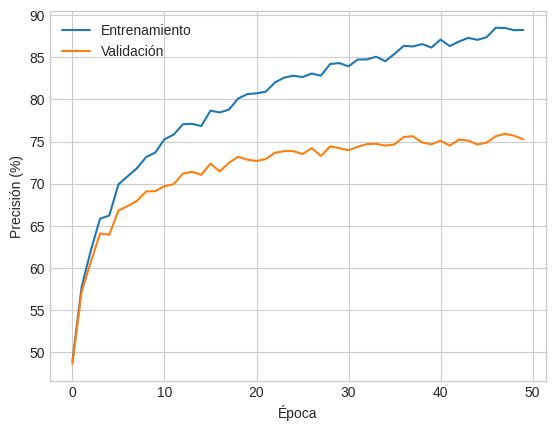

In [ ]:
# Instanciamos el modelo
model = CNN(dropout=0.5, normalization="layernorm").to(device)
print(model)

# Learning rate de 0.001 por defecto
optimizer = optim.Adam(model.parameters())

# Augmentations
augmentations = transforms.Compose([
    Lambda(lambda img: img * 255.), # Denormalize imagen
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(),]), p=0.3),
    Lambda(lambda img: img / 255.) # Normalizar imagen
  ]
)

# Nombre modelo
model_name = "ES+AUG+DROP+LN"

train_accs, valid_accs = train_model(model, epochs, train_loader, valid_loader, optimizer, criterion, augmentations, True, patience, model_name + ".pt")
print('Fin del entrenamiento.')

model = CNN(dropout=0.5, normalization="layernorm").to(device)
model.load_state_dict(torch.load(model_name + ".pt"))

# Obtenemos el accuracy del modelo en validación y en test
val_accuracy = test_model(model, valid_loader)
print(f'Tasa de acierto de validación = {val_accuracy:.2f}%')

test_accuracy = test_model(model, test_loader)
print(f'Tasa de acierto de test = {test_accuracy:.2f}%')

results_test[model_name] = test_accuracy


plt.plot(train_accs)
plt.plot(valid_accs)
plt.xlabel('Época')     # Eje X - Época
plt.ylabel('Tasa de acierto (%)')   # Eje Y - Tasa de acierto
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

In [ ]:
print(results_test)

{'baseline': 67.89, 'ES': 67.95, 'ES+AUG': 72.72, 'ES+AUG+DROP': 72.59, 'ES+AUG+DROP+BN': 76.93, 'ES+AUG+DROP+LN': 75.44}


## Comparativa de resultados

<ipython-input-36-cd6beb45b3cd>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


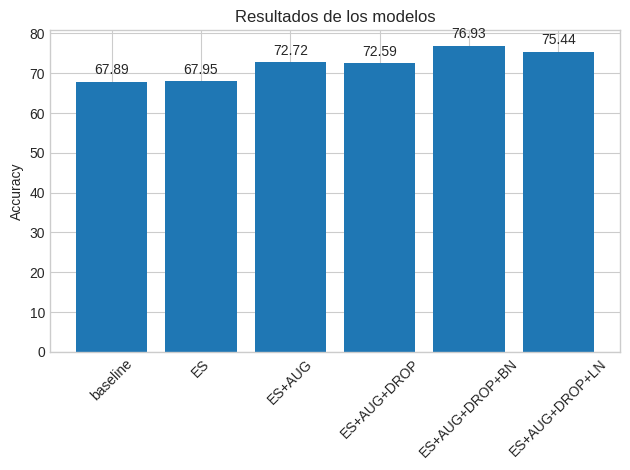

<ipython-input-36-cd6beb45b3cd>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


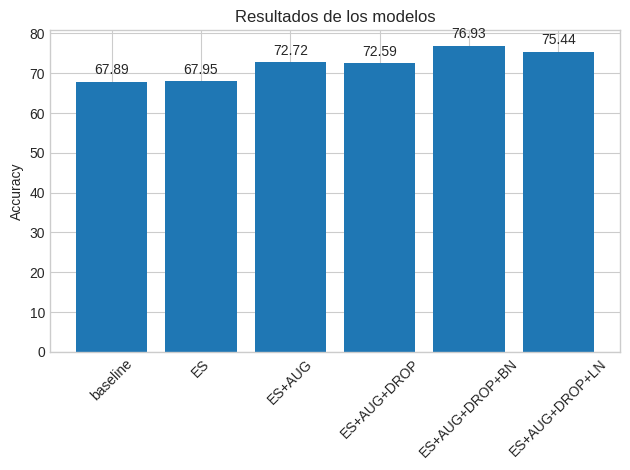

In [ ]:
# Obtener las etiquetas y los valores del diccionario
labels = list(results_test.keys())
values = list(results_test.values())

# Establecer el estilo del gráfico
plt.style.use('seaborn-whitegrid')

# Crear el gráfico de barras
fig, ax = plt.subplots()
bars = ax.bar(labels, values)

# Agregar etiquetas en el eje x y rotarlas para mayor claridad
plt.xticks(rotation=45)

# Agregar etiquetas en el eje y
plt.ylabel('Tasa de acierto (%)')

# Agregar título al gráfico
plt.title('Resultados de los modelos')

# Agregar etiquetas en el eje y para cada barra
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()